In [1]:
from fastai.tabular.all import *
from fastai.collab import *
import pandas as pd

In [4]:
books = pd.read_csv('../input/goodbooks-10k/books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


In [3]:
ratings = pd.read_csv('../input/goodbooks-10k/ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [5]:
# merge the ratings table with books
book_ratings = ratings.merge(books[['id', 'title']], left_on='book_id', right_on='id')
book_ratings.head()

,book_id,user_id,rating,id,title
0,1,314,5,1,"The Hunger Games (The Hunger Games, #1)"
1,1,439,3,1,"The Hunger Games (The Hunger Games, #1)"
2,1,588,5,1,"The Hunger Games (The Hunger Games, #1)"
3,1,1169,4,1,"The Hunger Games (The Hunger Games, #1)"
4,1,1185,4,1,"The Hunger Games (The Hunger Games, #1)"


In [6]:
# build a Dataloaders from the above table

dls = CollabDataLoaders.from_df(book_ratings, user_name='user_id', item_name='title',
                                rating_name='rating', bs=64)


In [7]:
dls.show_batch(max_n=5)

,user_id,title,rating
0,51167,Sign of the Unicorn (The Chronicles of Amber #3),3
1,36625,This Is Where It Ends,4
2,16766,Eiger Dreams: Ventures Among Men and Mountains,3
3,11837,"The Vampire Lestat (The Vampire Chronicles, #2)",3
4,30699,"Knots and Crosses (Inspector Rebus, #1)",5
5,20586,Black Holes and Baby Universes,3
6,5612,"The Third Wheel (Diary of a Wimpy Kid, #7)",5
7,12564,"Honeymoon (Honeymoon, #1)",4
8,33331,"Vanish (Rizzoli & Isles, #5)",4
9,17661,Skippyjon Jones,2


In [8]:
# train a collaborative filtering model by using collab_learner

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))


In [9]:
learn.summary()

EmbeddingDotBias (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 50             
Embedding                                 2652850    True      
Embedding                                 498250     True      
____________________________________________________________________________
                     64 x 1              
Embedding                                 53057      True      
Embedding                                 9965       True      
____________________________________________________________________________

Total params: 3,214,122
Total trainable params: 3,214,122
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f8fb4acfcb0>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

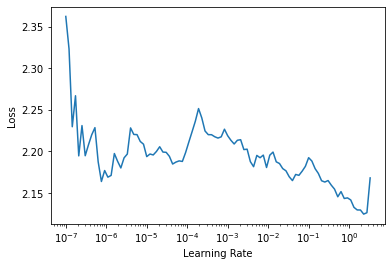

In [12]:
lr_min, lr_steep = learn.lr_find()

In [13]:
learn.fit_one_cycle(5, lr_min, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.996390,1.975515,08:39
1,1.984818,2.003063,14:04
2,1.858595,1.883243,13:26
3,1.494958,1.480672,10:06
4,1.124032,1.123166,09:01


In [15]:
# in interpretation we'll keep the 1000 most rated movies 

g = book_ratings.groupby('title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books[:10]


array(['Selected Poems', 'Stone Soup', 'Selected Stories', 'The List',
       'The Complete Stories and Poems', 'Invisible',
       'The Complete Stories', 'The Complete Poems',
       'Private (Private, #1)', 'The Beach House'], dtype=object)

In [16]:
# on book bias take the bias of each book in the top_books list

book_bias = learn.model.bias(top_books, is_item=True)

In [17]:
# compare the bias with average ratings

mean_ratings = book_ratings.groupby('title')['rating'].mean()
book_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_books, book_bias)]

In [19]:
# worst book bias
item0 = lambda o:o[0]
sorted(book_ratings, key=item0)[:15]

[(tensor(-0.1496), 'The Almost Moon', 2.49),
 (tensor(-0.1220), 'The Finkler Question', 2.67),
 (tensor(-0.1000), 'Tell-All', 2.61),
 (tensor(-0.0734), 'The 3 Mistakes of My Life', 2.43),
 (tensor(-0.0354), 'The Devil Wears Prada (The Devil Wears Prada, #1)', 3.32),
 (tensor(-0.0298), 'The Colorado Kid (Hard Case Crime #13)', 3.03),
 (tensor(-0.0035), 'The Awakening (The Vampire Diaries, #1)', 3.3),
 (tensor(0.0043), 'State of Fear', 3.34),
 (tensor(0.0061), 'Skinny Bitch', 2.9),
 (tensor(0.0062), "The Emperor's Children", 2.71),
 (tensor(0.0105), 'Snow', 3.17),
 (tensor(0.0116), 'Something Borrowed (Darcy & Rachel, #1)', 3.14),
 (tensor(0.0154), 'Telegraph Avenue', 3.2),
 (tensor(0.0154), 'The Bridges of Madison County', 3.19),
 (tensor(0.0155), 'Songs of the Humpback Whale', 3.07)]

In [20]:
# best book bias
sorted(book_ratings, key=item0, reverse=True)[:15]

[(tensor(0.5996), 'Selected Poems', 4.08),
 (tensor(0.5815),
  'The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury',
  4.75),
 (tensor(0.5811), 'The Complete Stories', 4.32),
 (tensor(0.5711), "One Flew Over the Cuckoo's Nest", 4.276923076923077),
 (tensor(0.5674), 'The Complete Calvin and Hobbes', 4.73),
 (tensor(0.5566),
  'The Days Are Just Packed: A Calvin and Hobbes Collection',
  4.78),
 (tensor(0.5435), 'Anatomy for the Artist', 4.121387283236994),
 (tensor(0.5424), 'Stone Soup', 4.206666666666667),
 (tensor(0.5327), 'The Complete Novels', 4.52),
 (tensor(0.5303), 'The Assassin and the Desert (Throne of Glass, #0.3)', 4.44),
 (tensor(0.5237), 'The Far Side Gallery', 4.41),
 (tensor(0.5088), "The Emperor's Soul", 4.31),
 (tensor(0.4948), 'The Complete Stories and Poems', 4.255),
 (tensor(0.4931), 'The Absolute Sandman, Volume One', 4.71),
 (tensor(0.4888), 'The Essential Rumi', 4.45)]

In [21]:
# on book weights we take the weights of each book in the top_books list
book_w = learn.model.weight(top_books, is_item=True)
book_w.shape

torch.Size([1000, 50])

In [22]:
# we use a PCA to reduce the dimension and find out what the model learnt
book_pca = book_w.pca(3)
book_pca.shape

torch.Size([1000, 3])

In [23]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books)]

In [24]:
# highest dimension score 
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]


[(tensor(0.4189), 'The Almost Moon'),
 (tensor(0.4122), 'Snow'),
 (tensor(0.3915),
  'The Boleyn Inheritance (The Plantagenet and Tudor Novels, #10)'),
 (tensor(0.3891), 'Solar'),
 (tensor(0.3851), 'Anatomy for the Artist'),
 (tensor(0.3807), 'Something from the Nightside (Nightside, #1)'),
 (tensor(0.3797), 'Stenhuggaren (Patrik Hedström, #3)'),
 (tensor(0.3725), 'The Broom of the System'),
 (tensor(0.3580), 'Telegraph Avenue'),
 (tensor(0.3575), 'The Dharma Bums')]

In [26]:
# worst score
sorted(book_comp, key=itemgetter(0))[:10]


[(tensor(-0.7095), 'Bambi'),
 (tensor(-0.7036), 'Stone Soup'),
 (tensor(-0.6782), 'Survivor In Death (In Death, #20)'),
 (tensor(-0.6012), 'Snow White and the Seven Dwarfs (Little Golden Book)'),
 (tensor(-0.5262), 'The Darkest Night (Lords of the Underworld #1)'),
 (tensor(-0.5002), 'The Darkest Whisper (Lords of the Underworld #4)'),
 (tensor(-0.4875), 'Sin Undone (Demonica #5)'),
 (tensor(-0.4725), 'The Little Mermaid'),
 (tensor(-0.4702), "The Day Jimmy's Boa Ate the Wash"),
 (tensor(-0.4474), 'Thankless in Death (In Death, #37)')]

In [27]:
# lets check the second dimension
book_comp = [(f, i) for f,i in zip(fac1, top_books)]

In [28]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.3371),
  'The Beautiful Mystery (Chief Inspector Armand Gamache, #8)'),
 (tensor(0.3047), 'Stone Soup'),
 (tensor(0.2809), 'The Day of the Triffids'),
 (tensor(0.2743), 'Sleeping Murder (Miss Marple, #13)'),
 (tensor(0.2717), 'The Calvin and Hobbes Lazy Sunday Book'),
 (tensor(0.2710), 'T is for Trespass (Kinsey Millhone, #20)'),
 (tensor(0.2673), 'The Essential Rumi'),
 (tensor(0.2667), 'The Bone Tree'),
 (tensor(0.2632), 'The Bourne Identity (Jason Bourne, #1)'),
 (tensor(0.2632), 'The English Assassin (Gabriel Allon, #2)')]

In [29]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.6720), 'The Darkest Secret (Lords of the Underworld #7)'),
 (tensor(-0.5587), 'The Darkest Whisper (Lords of the Underworld #4)'),
 (tensor(-0.5534), 'The Darkest Minds (The Darkest Minds, #1)'),
 (tensor(-0.4960), 'The Darkest Lie (Lords of the Underworld #6)'),
 (tensor(-0.4905), 'The Dream Hunter (Dark-Hunter #10, Dream-Hunter #1)'),
 (tensor(-0.4685), 'Sweet Home (Sweet Home, #1)'),
 (tensor(-0.4633), 'Sweet Peril (Sweet, #2)'),
 (tensor(-0.4516), 'The Darkest Seduction (Lords of the Underworld #9)'),
 (tensor(-0.4439), 'Sixth Grave on the Edge (Charley Davidson, #6)'),
 (tensor(-0.4412), 'Sin Undone (Demonica #5)')]

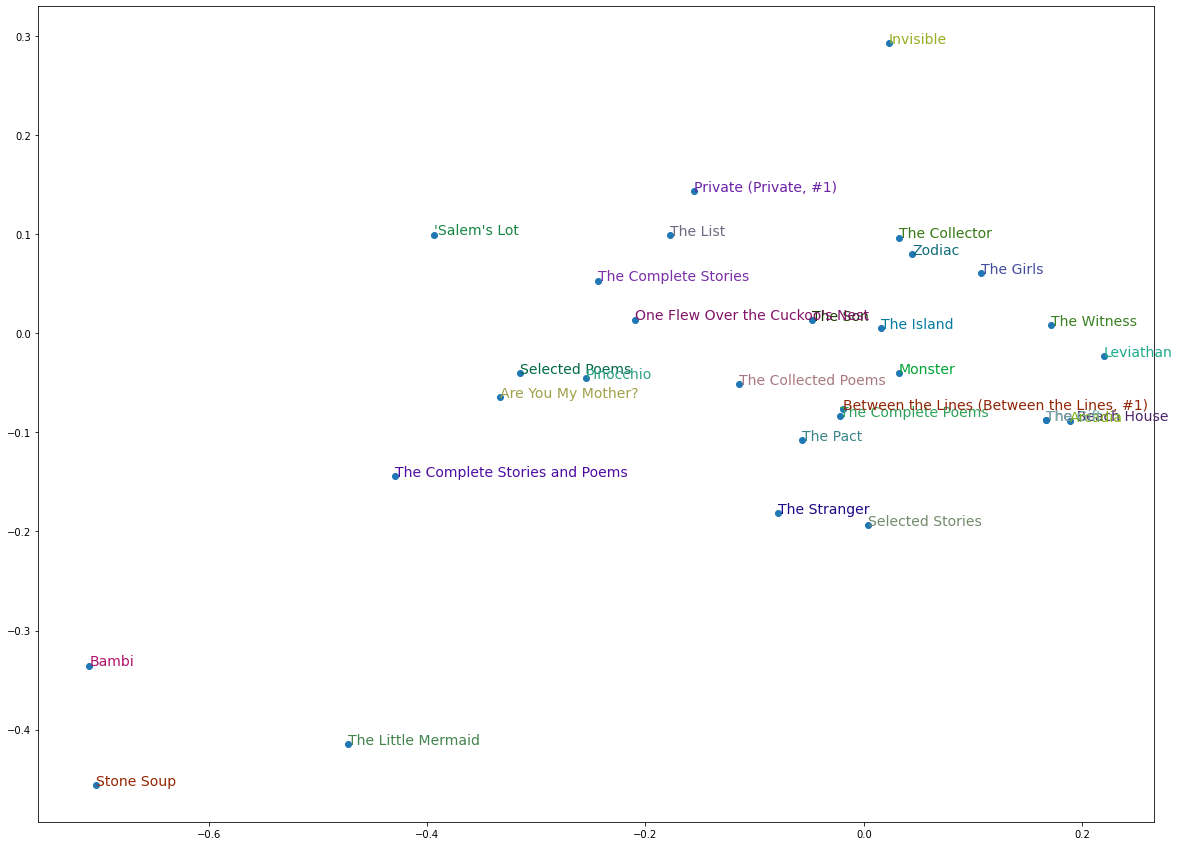

In [30]:
# lets plot the books according to their scores on the dimensions

idxs = np.random.choice(len(top_books), 30, replace=False)
idxs = list(range(30))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(20,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=14)
plt.show()